In [1]:
!git clone -b dev https://github.com/dokunoale/chagas.git
!pip install -r chagas/requirements.txt

# Download the dataset
import gdown

url = "https://drive.google.com/file/d/1vK_gMI36xjdtiJjMBV7dKHurIExQs4hC/view?usp=drive_link"
gdown.download(url, "dataset.zip", quiet=False, fuzzy=True)
!unzip -q /content/dataset.zip -d chagas/data/

Cloning into 'chagas'...
remote: Enumerating objects: 546, done.
remote: Counting objects: 100% (108/108), done.
remote: Compressing objects: 100% (81/81), done.
remote: Total 546 (delta 53), reused 62 (delta 27), pack-reused 438 (from 1)
Receiving objects: 100% (546/546), 5.40 MiB | 20.03 MiB/s, done.
Resolving deltas: 100% (267/267), done.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 53.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 72.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.0/160.0 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.8/301.8 kB 22.9 MB/s eta 0:00:00
  Attempting uninstall: joblib
    Found existing installation: joblib 1.5.1
    Uninstalling joblib-1.5.1:
      Successfully uninstalled joblib-1.5.1
  Attempting uninstall: h5py
    Found existing installation: h5py 3.14.0
    Uninstalling h5py-3.14.0:
      Successfully uninstalled h5py-3.14.0
  Attempting uninstall: scikit-learn
  

Downloading...
From (original): https://drive.google.com/uc?id=1vK_gMI36xjdtiJjMBV7dKHurIExQs4hC
From (redirected): https://drive.google.com/uc?id=1vK_gMI36xjdtiJjMBV7dKHurIExQs4hC&confirm=t&uuid=cf9a6280-8fcf-45c7-b8a8-8f98f21af25b
To: /content/dataset.zip
100%|██████████| 623M/623M [00:02<00:00, 275MB/s]


In [2]:
import sys
sys.path.append("/content/chagas/src")

import tensorflow as tf
from tensorflow.keras.layers import Layer
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.metrics import AUC

In [3]:
from preprocessing.tf_dataset_loader import WfdbLoader
from preprocessing.filters import FiltfiltNoiseReducer

# Carichiamo il dataset
data_path = "/content/chagas/data/big_splitted_dataset/"

filter = FiltfiltNoiseReducer(fs=400, iir_freq=60.0, butterworth_cutoff=5., lowpass_cutoff=60., verbose=True)

train = WfdbLoader(label = 'Chagas label')
train.add_filter(filter)
train.add_dataset(data_path + "train/positives")
train.add_dataset(data_path + "train/negatives")
X_train, y_train = train.load(shuffle=True, verbose=True)

validation = WfdbLoader(label = 'Chagas label')
validation.add_filter(filter)
validation.add_dataset(data_path + "val/positives")
validation.add_dataset(data_path + "val/negatives")
X_val, y_val = validation.load(shuffle=True, verbose=True)

test = WfdbLoader(label = 'Chagas label')
test.add_filter(filter)
test.add_dataset(data_path + "test/positives")
test.add_dataset(data_path + "test/negatives")
X_test, y_test = test.load(shuffle=True, verbose=True)

y_test_info = test.get_metadata()

Filtering records - filtfilt: 100%|██████████| 2245/2245 [00:13<00:00, 161.53record/s]


# Training

In [26]:
from models.layers import LightLogSpectrogram

@tf.keras.utils.register_keras_serializable()
class TemporalMeanPooling(tf.keras.layers.Layer):
    def call(self, inputs):
        return tf.reduce_mean(inputs, axis=2)

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[1], input_shape[3])

def build_cnn_model(input_shape=(2800, 12)):
    inputs = tf.keras.Input(shape=input_shape)  # 12-lead ECG time series

    # Logarithmic spectrogram
    x = LightLogSpectrogram()(inputs)  # shape: [batch, time, freq, 12]

    # Simple Conv2D block
    x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', name="conv_32")(x)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='conv_64')(x)
    x = TemporalMeanPooling(name="temporal_pooling")(x)

    # GRU con 64 canali in input
    x = tf.keras.layers.Bidirectional(
        tf.keras.layers.GRU(32, return_sequences=True),
        merge_mode='ave',
        name='bigru_32_sequence'
    )(x)  # output: (batch, time, 32)

    x = tf.keras.layers.Bidirectional(
        tf.keras.layers.GRU(32, return_sequences=False),
        merge_mode='ave',
        name='bigru_32'
    )(x)  # output: (batch, time, 32)

    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)  # Binary output

    return tf.keras.Model(inputs, outputs, name="RCNN")

# Compilazione del modello
model = build_cnn_model(input_shape=(2800, 12))
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', AUC(name='auc')]
)

model.summary()

Model: "RCNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 2800, 12)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ light_log_spectrogram_5         │ (None, 88, 64, 12)     │             0 │
│ (LightLogSpectrogram)           │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_32 (Conv2D)                │ (None, 88, 64, 32)     │         3,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 44, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_64 (Conv2D)                │ (None, 44, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ temporal_pooling                │ (None, 44, 64)         │             0 │
│ (TemporalMeanPooling)           │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bigru_32_sequence               │ (None, 44, 32)         │        18,816 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bigru_32 (Bidirectional)        │ (None, 32)             │        12,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 53,505 (209.00 KB)

 Trainable params: 53,505 (209.00 KB)

 Non-trainable params: 0 (0.00 B)

In [27]:
# Callback: early stopping e salvataggio del modello migliore
early_stop = EarlyStopping(monitor='val_auc', patience=10, mode='max', restore_best_weights=True)
checkpoint = ModelCheckpoint("best_model.keras", monitor='val_auc', mode='max', save_best_only=True)

callbacks = [early_stop, checkpoint]

# Training
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=30,
    callbacks=callbacks
)

Epoch 1/50
262/262 ━━━━━━━━━━━━━━━━━━━━ 19s 44ms/step - accuracy: 0.5090 - auc: 0.5045 - loss: 0.6958 - val_accuracy: 0.5045 - val_auc: 0.5999 - val_loss: 0.6907
Epoch 2/50
262/262 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - accuracy: 0.5729 - auc: 0.6031 - loss: 0.6761 - val_accuracy: 0.6471 - val_auc: 0.7112 - val_loss: 0.6244
Epoch 3/50
262/262 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - accuracy: 0.6698 - auc: 0.7262 - loss: 0.6099 - val_accuracy: 0.6569 - val_auc: 0.7299 - val_loss: 0.6090
Epoch 4/50
262/262 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/step - accuracy: 0.6791 - auc: 0.7446 - loss: 0.5943 - val_accuracy: 0.6925 - val_auc: 0.7760 - val_loss: 0.5789
Epoch 5/50
262/262 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.6994 - auc: 0.7756 - loss: 0.5683 - val_accuracy: 0.7184 - val_auc: 0.7944 - val_loss: 0.5536
Epoch 6/50
262/262 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.7239 - auc: 0.8048 - loss: 0.5358 - val_accuracy: 0.7184 - val_auc: 0.8014 - val_loss: 0.5421
Epoch 7/50
262/262 ━━━━━━━━━━━

36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step
Optimal threshold: 0.440
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


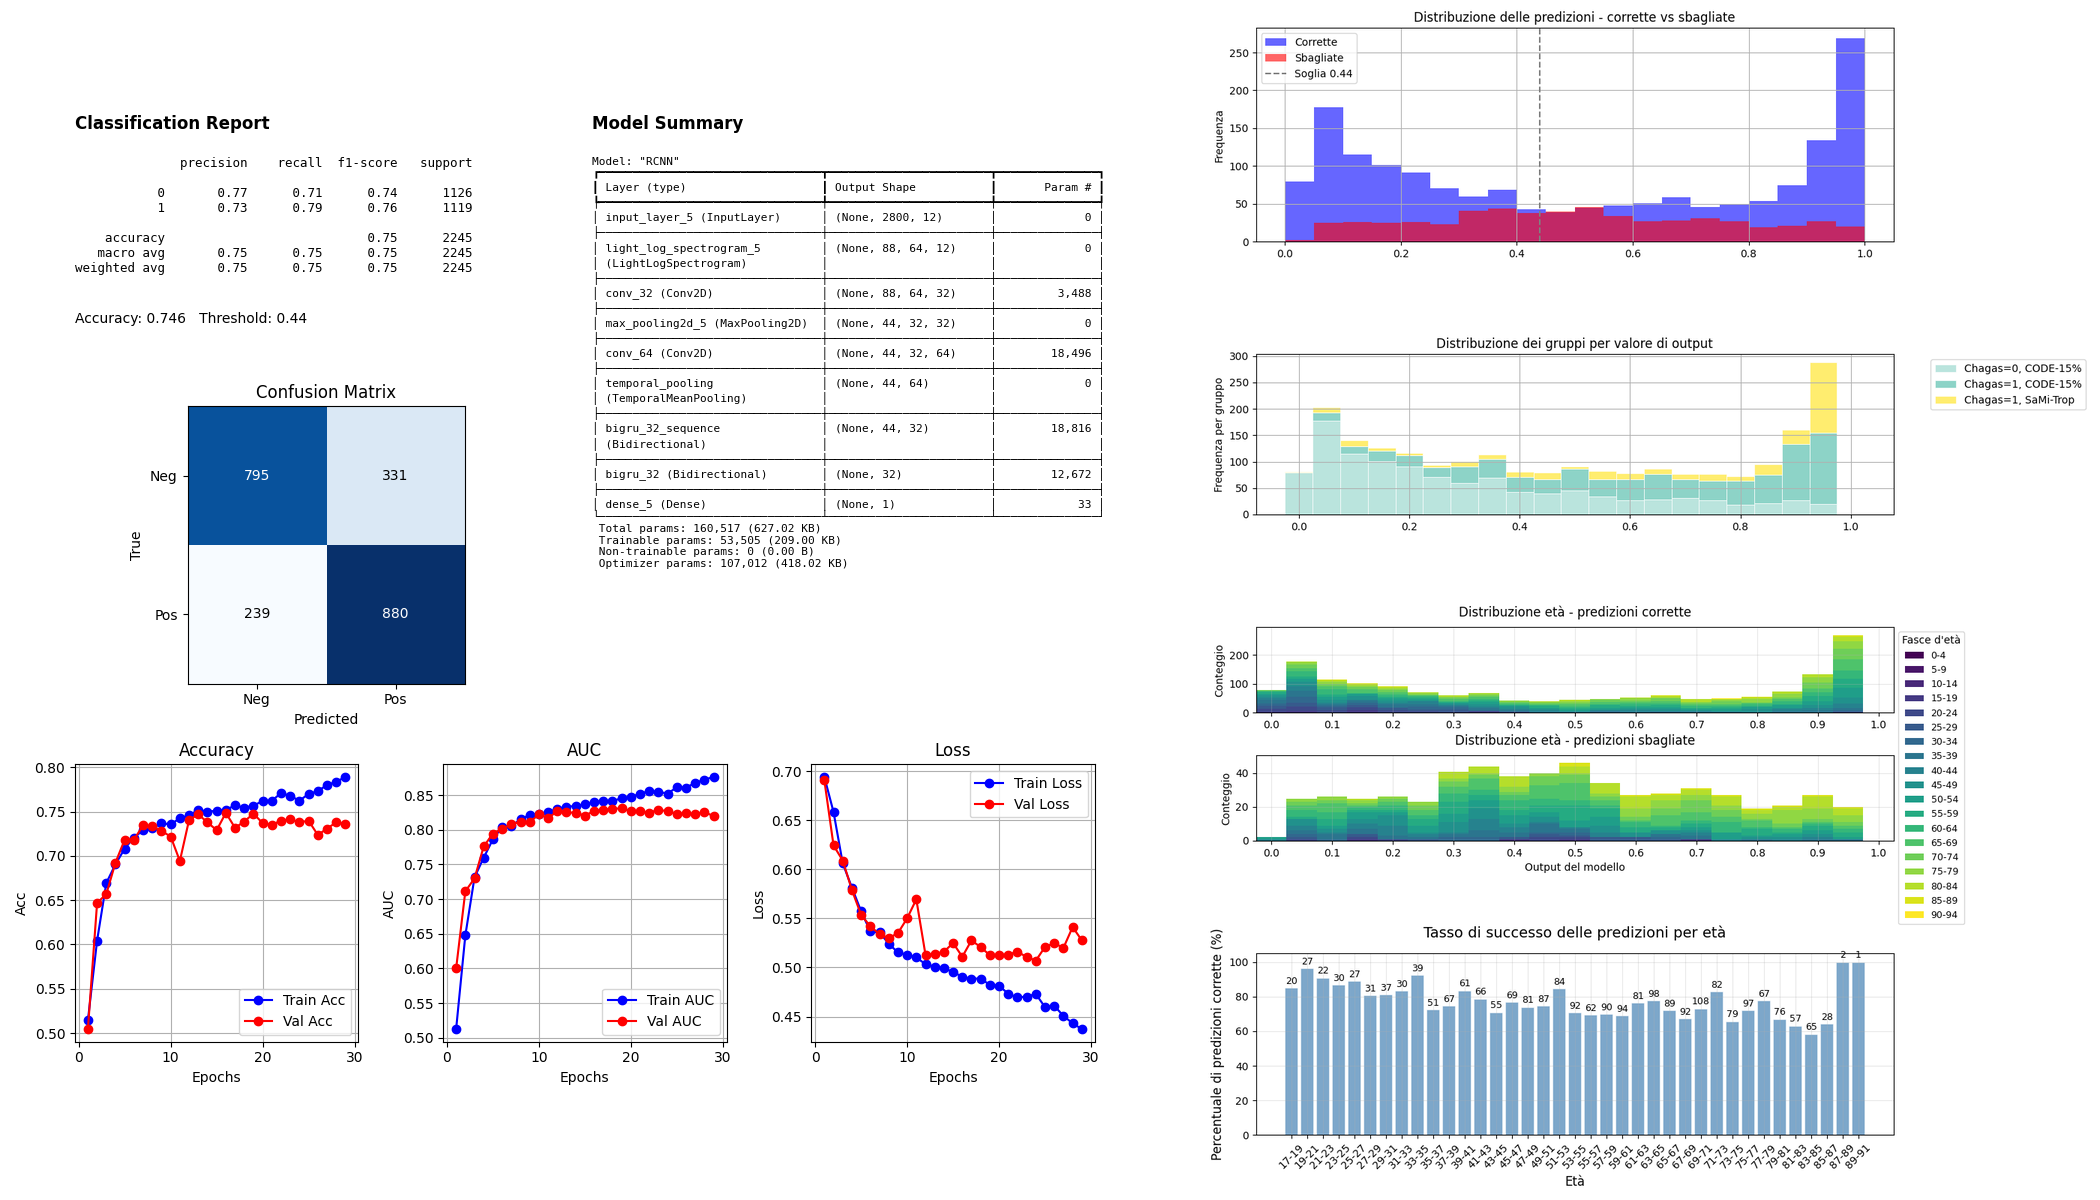

In [33]:
from models.utils import find_optimal_threshold
from models.analysis import plot_full_report_and_metrics, plot_model_analysis
from PIL import Image

model = tf.keras.models.load_model("best_model.keras", safe_mode=False)

y_pred_probs = model.predict(X_val)
threshold = find_optimal_threshold(y_val, y_pred_probs)

img1 = plot_full_report_and_metrics(model, X_test, y_test, history, threshold, return_pillow=True)
img2 = plot_model_analysis(model, X_test, y_test, y_test_info, threshold, return_pillow=True, label_keys=['Chagas', 'Source'])

# 1. Ridimensiona img2 all'altezza di img1, mantenendo le proporzioni
new_height = int(img1.height * 1.2)
new_width = int(img2.width * (new_height / img2.height))
img2_resized = img2.resize((new_width, new_height), Image.LANCZOS)

# 2. Calcola la nuova immagine
total_width = img1.width + img2_resized.width
max_height = max(img1.height, img2_resized.height)
new_img = Image.new('RGB', (total_width, max_height), color=(255, 255, 255))

# 3. Centra verticalmente img1 (se img1 è più bassa di max_height)
y_offset_img1 = (max_height - img1.height) // 2
y_offset_img2 = (max_height - img2_resized.height) // 2

new_img.paste(img1, (0, y_offset_img1))
new_img.paste(img2_resized, (img1.width, y_offset_img2))

# 4. Visualizza nel notebook
display(new_img)

## Utils

In [8]:
def make_all_gradcam_heatmaps(ecg_sample, model, last_conv_layer_name="conv2d_1", pred_index=None):
    grad_model = tf.keras.models.Model(
        inputs=model.input,
        outputs=[
            model.get_layer(last_conv_layer_name).output,
            model.output
        ]
    )

    ecg_input = tf.expand_dims(ecg_sample, axis=0)  # (1, 2800, 12)

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(ecg_input)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)
    conv_outputs = conv_outputs[0]  # (H, W, C)
    grads = grads[0]                # (H, W, C)

    # Calcolo di tutte le 32 heatmap, una per canale
    heatmaps = []
    for i in range(conv_outputs.shape[-1]):
        weighted_map = conv_outputs[..., i] * grads[..., i]
        heatmap = tf.maximum(weighted_map, 0)
        heatmap = heatmap / (tf.reduce_max(heatmap) + tf.keras.backend.epsilon())
        heatmaps.append(heatmap.numpy())

    return heatmaps  # Lista di 32 heatmap (H, W)

def get_spectrogram(model, sample):
    spectrogram_model = tf.keras.Model(inputs=model.input, outputs=model.get_layer(index=1).output)
    sample = tf.expand_dims(sample, axis=0)  # (1, 2800, 12)
    spectrogram = spectrogram_model(sample)  # (1, 88, 64, 12)
    return spectrogram[0]  # (88, 64, 12)

def display_all_heatmaps(heatmaps, cols=8):
    import matplotlib.pyplot as plt
    rows = (len(heatmaps) + cols - 1) // cols
    plt.figure(figsize=(2*cols, 2*rows))
    for i, heatmap in enumerate(heatmaps):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(heatmap, cmap='jet')
        plt.title(f'Channel {i}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()


def display_all_heatmaps_on_spectrogram(spectrogram, heatmaps, cols=8, alpha=0.4):
    import matplotlib.pyplot as plt
    import tensorflow as tf

    spectrogram_gray = tf.reduce_mean(spectrogram, axis=-1)  # (H, W)

    rows = (len(heatmaps) + cols - 1) // cols
    plt.figure(figsize=(2.5*cols, 2.5*rows))

    for i, heatmap in enumerate(heatmaps):
        heatmap_resized = tf.image.resize(heatmap[..., tf.newaxis], spectrogram_gray.shape).numpy()

        plt.subplot(rows, cols, i + 1)
        plt.imshow(spectrogram_gray, cmap='gray')
        plt.imshow(heatmap_resized[..., 0], cmap='jet', alpha=alpha)
        plt.title(f'Channel {i}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()


In [22]:
def make_all_gradcam_heatmaps_gru(ecg_sample, model, gru_layer_name="gru", pred_index=None):
    """
    Genera heatmaps GradCAM per un modello con layer GRU
    """
    # Trova il layer GRU e verifica se restituisce sequenze
    gru_layer = model.get_layer(gru_layer_name)

    grad_model = tf.keras.models.Model(
        inputs=model.input,
        outputs=[
            gru_layer.output,
            model.output
        ]
    )

    ecg_input = tf.expand_dims(ecg_sample, axis=0)  # (1, 2800, 12)

    with tf.GradientTape() as tape:
        gru_outputs, predictions = grad_model(ecg_input)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, gru_outputs)

    # Debug: stampa le forme per capire la struttura
    print(f"GRU outputs shape: {gru_outputs.shape}")
    print(f"Gradients shape: {grads.shape}")

    # Rimuovi la dimensione batch
    if len(gru_outputs.shape) == 3:  # (batch, timesteps, units)
        gru_outputs = gru_outputs[0]  # (timesteps, units)
        grads = grads[0]              # (timesteps, units)
    elif len(gru_outputs.shape) == 2:  # (batch, units) - solo ultimo output
        gru_outputs = gru_outputs[0]  # (units,)
        grads = grads[0]              # (units,)
        print("WARNING: GRU layer returns only last output, not full sequence")

    # Calcolo delle heatmap
    heatmaps = []
    if len(gru_outputs.shape) == 2:  # Sequenza completa
        for i in range(gru_outputs.shape[-1]):
            weighted_map = gru_outputs[..., i] * grads[..., i]
            heatmap = tf.maximum(weighted_map, 0)
            heatmap = heatmap / (tf.reduce_max(heatmap) + tf.keras.backend.epsilon())
            heatmaps.append(heatmap.numpy())
    else:  # Solo ultimo output
        for i in range(gru_outputs.shape[-1]):
            weighted_val = gru_outputs[i] * grads[i]
            heatmap = tf.maximum(weighted_val, 0)
            heatmap = heatmap / (tf.reduce_max(heatmap) + tf.keras.backend.epsilon())
            heatmaps.append(heatmap.numpy())

    return heatmaps

def get_gru_states(model, sample, gru_layer_name="gru"):
    """
    Estrae gli stati del layer GRU
    """
    gru_model = tf.keras.Model(inputs=model.input, outputs=model.get_layer(gru_layer_name).output)
    sample = tf.expand_dims(sample, axis=0)  # (1, 2800, 12)
    gru_states = gru_model(sample)  # (1, timesteps, gru_units)
    return gru_states[0]  # (timesteps, gru_units)

def display_all_heatmaps_gru(heatmaps, cols=8):
    """
    Visualizza tutte le heatmaps GRU come grafici temporali o bar chart
    """
    import matplotlib.pyplot as plt
    import numpy as np

    # Controlla se le heatmaps sono scalari o array
    if isinstance(heatmaps[0], (int, float, np.float32, np.float64)):
        # Heatmaps sono scalari - mostra come bar chart
        plt.figure(figsize=(12, 6))
        plt.bar(range(len(heatmaps)), heatmaps)
        plt.title('GRU Unit Importance Scores')
        plt.xlabel('GRU Unit')
        plt.ylabel('Importance Score')
        plt.grid(True, alpha=0.3)
        plt.show()
        return

    # Heatmaps sono array - mostra come grafici temporali
    rows = (len(heatmaps) + cols - 1) // cols
    plt.figure(figsize=(3*cols, 2*rows))

    for i, heatmap in enumerate(heatmaps):
        plt.subplot(rows, cols, i + 1)
        plt.plot(heatmap)
        plt.title(f'GRU Unit {i}')
        plt.xlabel('Timestep')
        plt.ylabel('Activation')
        plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

def display_heatmaps_on_ecg(ecg_sample, heatmaps, selected_units=None, alpha=0.8, threshold=0.3):
    """
    Sovrappone le heatmaps GRU sui segnali ECG originali con attivazioni più evidenti
    """
    import matplotlib.pyplot as plt
    import numpy as np

    # Controlla se le heatmaps sono scalari o array
    if isinstance(heatmaps[0], (int, float, np.float32, np.float64)):
        print("WARNING: Heatmaps are scalars (GRU returns only last output)")
        print("Cannot display temporal evolution. Showing unit importance instead.")

        # Visualizza l'importanza delle unità GRU
        plt.figure(figsize=(12, 6))
        plt.bar(range(len(heatmaps)), heatmaps)
        plt.title('GRU Unit Importance')
        plt.xlabel('GRU Unit')
        plt.ylabel('Importance Score')
        plt.grid(True, alpha=0.3)
        plt.show()

        # Mostra anche il segnale ECG originale
        plt.figure(figsize=(15, 8))
        for i in range(min(12, ecg_sample.shape[1])):
            plt.subplot(3, 4, i+1)
            plt.plot(ecg_sample[:, i])
            plt.title(f'Lead {i+1}')
            plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
        return

    if selected_units is None:
        # Seleziona le prime 4 unità più attive
        activations = [np.sum(hm) for hm in heatmaps]
        selected_units = np.argsort(activations)[-4:]

    fig, axes = plt.subplots(len(selected_units), 1, figsize=(15, 3*len(selected_units)))
    if len(selected_units) == 1:
        axes = [axes]

    for idx, unit in enumerate(selected_units):
        # Ridimensiona la heatmap per matchare la lunghezza del segnale ECG
        heatmap_resized = np.interp(
            np.linspace(0, len(heatmaps[unit]), len(ecg_sample)),
            np.arange(len(heatmaps[unit])),
            heatmaps[unit]
        )

        # Applica una soglia per evidenziare solo le attivazioni significative
        heatmap_thresholded = np.where(heatmap_resized > threshold, heatmap_resized, 0)

        # Plotta il segnale ECG medio
        ecg_mean = np.mean(ecg_sample, axis=1)
        axes[idx].plot(ecg_mean, 'b-', alpha=0.7, label='ECG Signal', linewidth=1.5)

        # Crea una colormap per le attivazioni
        norm_heatmap = heatmap_thresholded / (np.max(heatmap_thresholded) + 1e-8)

        # Sovrappone la heatmap con colori più intensi
        for i in range(len(ecg_mean)):
            if norm_heatmap[i] > 0:
                # Colore più intenso per attivazioni forti
                color_intensity = norm_heatmap[i]
                axes[idx].axvspan(i-0.5, i+0.5,
                                alpha=alpha * color_intensity,
                                color='red',
                                label='High Activation' if i == np.argmax(norm_heatmap) else "")

        # Aggiungi linee verticali per i picchi di attivazione
        peaks = np.where(norm_heatmap > 0.7)[0]  # Trova i picchi sopra 0.7
        for peak in peaks:
            axes[idx].axvline(x=peak, color='orange', linestyle='--', alpha=0.8, linewidth=2)

        axes[idx].set_title(f'ECG with GRU Unit {unit} Activation (Activation Sum: {np.sum(heatmaps[unit]):.3f})')
        axes[idx].set_xlabel('Time')
        axes[idx].set_ylabel('Amplitude')
        axes[idx].legend()
        axes[idx].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

def analyze_temporal_attention(heatmaps, window_size=100):
    """
    Analizza l'attenzione temporale delle unità GRU con controlli migliorati
    """
    import matplotlib.pyplot as plt
    import numpy as np

    # Controlla se le heatmaps sono scalari
    if isinstance(heatmaps[0], (int, float, np.float32, np.float64)):
        print("WARNING: Cannot analyze temporal attention with scalar heatmaps")
        print("GRU layer returns only last output, not full sequence")
        return np.array(heatmaps).reshape(1, -1)

    # Verifica che ci siano abbastanza timesteps
    if len(heatmaps[0]) < window_size:
        print(f"WARNING: Sequence length ({len(heatmaps[0])}) is shorter than window_size ({window_size})")
        window_size = max(1, len(heatmaps[0]) // 10)  # Usa almeno 10 finestre
        print(f"Using adjusted window_size: {window_size}")

    # Calcola l'attenzione media per finestre temporali
    n_windows = max(1, len(heatmaps[0]) // window_size)
    attention_matrix = np.zeros((len(heatmaps), n_windows))

    for i, heatmap in enumerate(heatmaps):
        for j in range(n_windows):
            start_idx = j * window_size
            end_idx = min((j + 1) * window_size, len(heatmap))
            if end_idx > start_idx:  # Verifica che la finestra non sia vuota
                attention_matrix[i, j] = np.mean(heatmap[start_idx:end_idx])

    # Controlla se la matrice ha varianza sufficiente
    if np.var(attention_matrix) < 1e-10:
        print("WARNING: Attention matrix has very low variance")
        # Aggiungi un po' di rumore per evitare problemi di visualizzazione
        attention_matrix += np.random.normal(0, 1e-6, attention_matrix.shape)

    plt.figure(figsize=(12, 8))

    # Usa vmin e vmax per evitare problemi con valori identici
    vmin = np.min(attention_matrix)
    vmax = np.max(attention_matrix)
    if vmax == vmin:
        vmax = vmin + 1e-6

    im = plt.imshow(attention_matrix, cmap='viridis', aspect='auto', vmin=vmin, vmax=vmax)
    plt.colorbar(im, label='Attention Score')
    plt.xlabel('Time Windows')
    plt.ylabel('GRU Units')
    plt.title(f'Temporal Attention Pattern (Window size: {window_size})')

    # Aggiungi informazioni sulla matrice
    plt.figtext(0.02, 0.02, f'Matrix shape: {attention_matrix.shape}, Variance: {np.var(attention_matrix):.6f}',
                fontsize=8, ha='left')

    plt.show()

    return attention_matrix

## X-rays


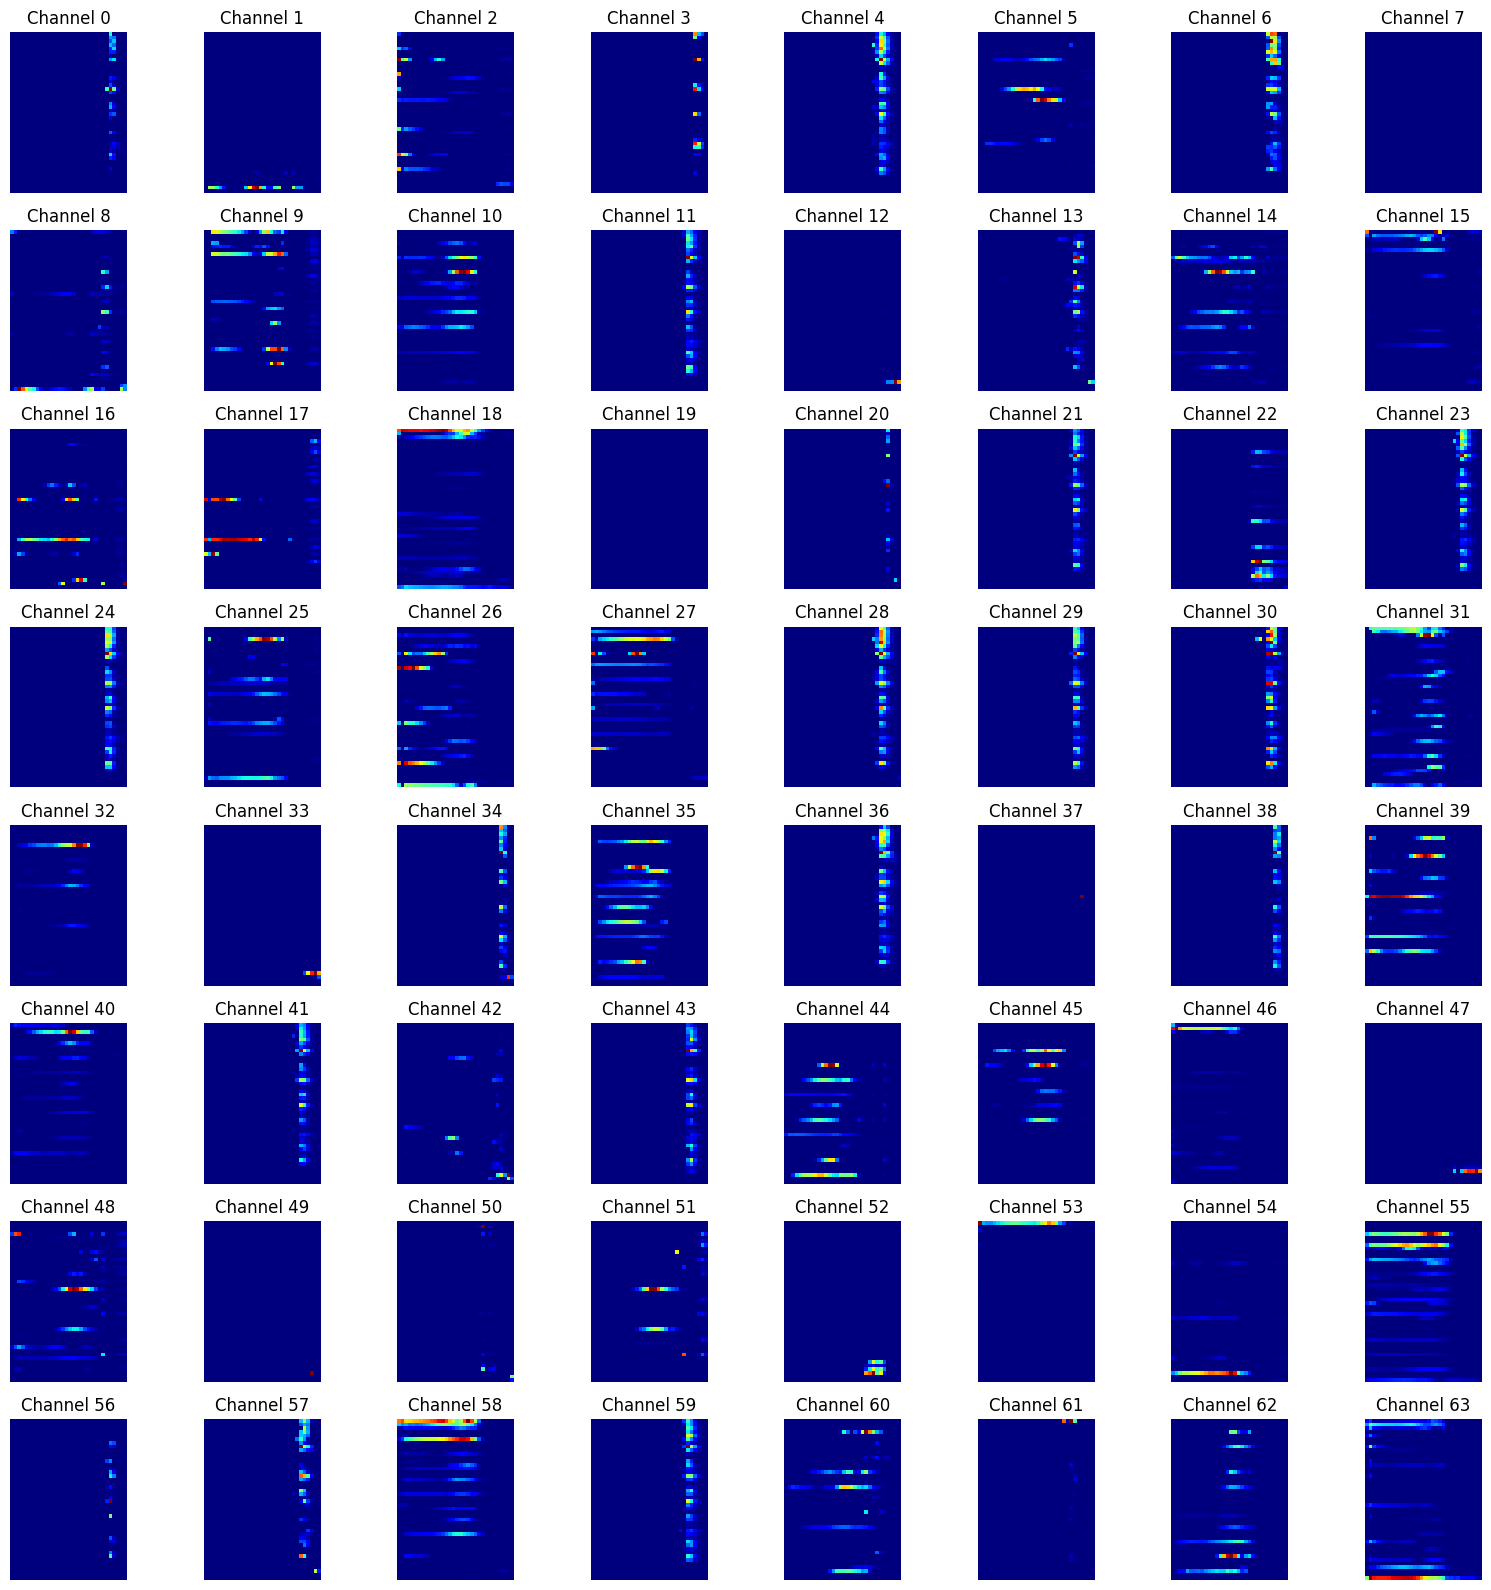

chagas: 0 - source: CODE-15%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
[[0.07338011]]
GRU outputs shape: (1, 44, 32)
Gradients shape: (1, 44, 32)


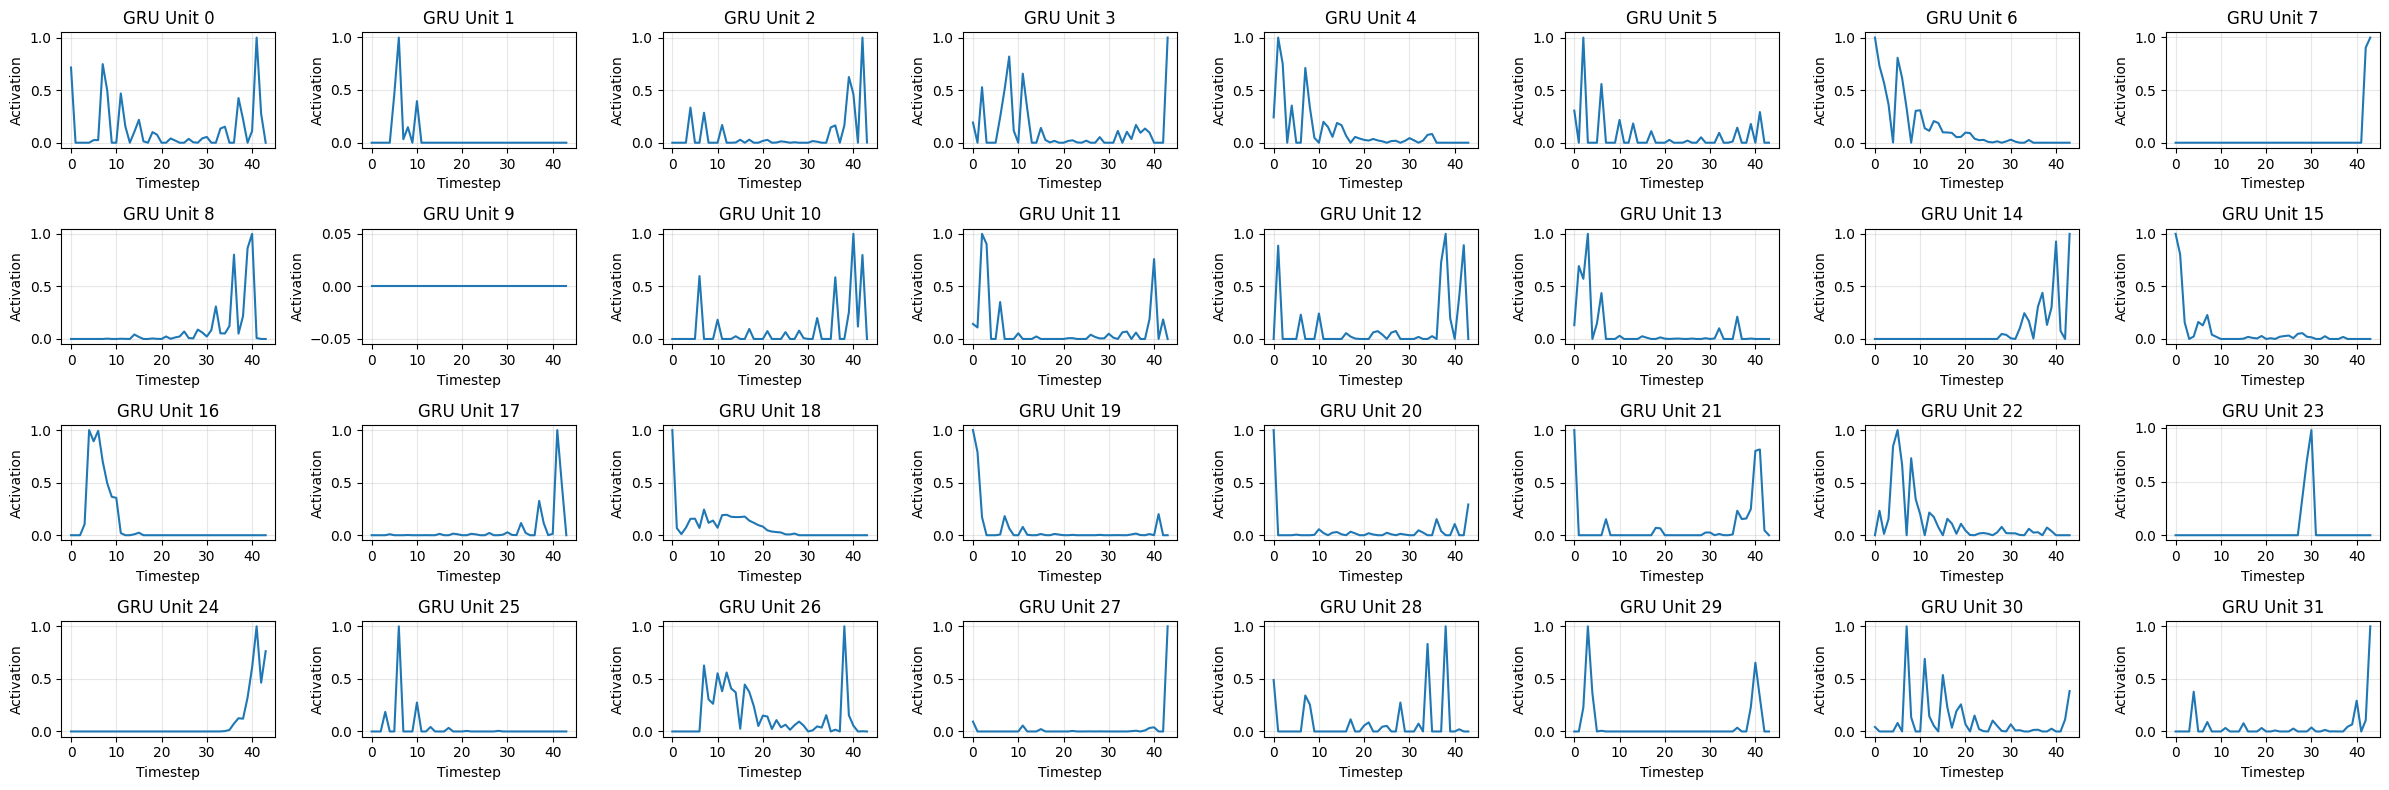

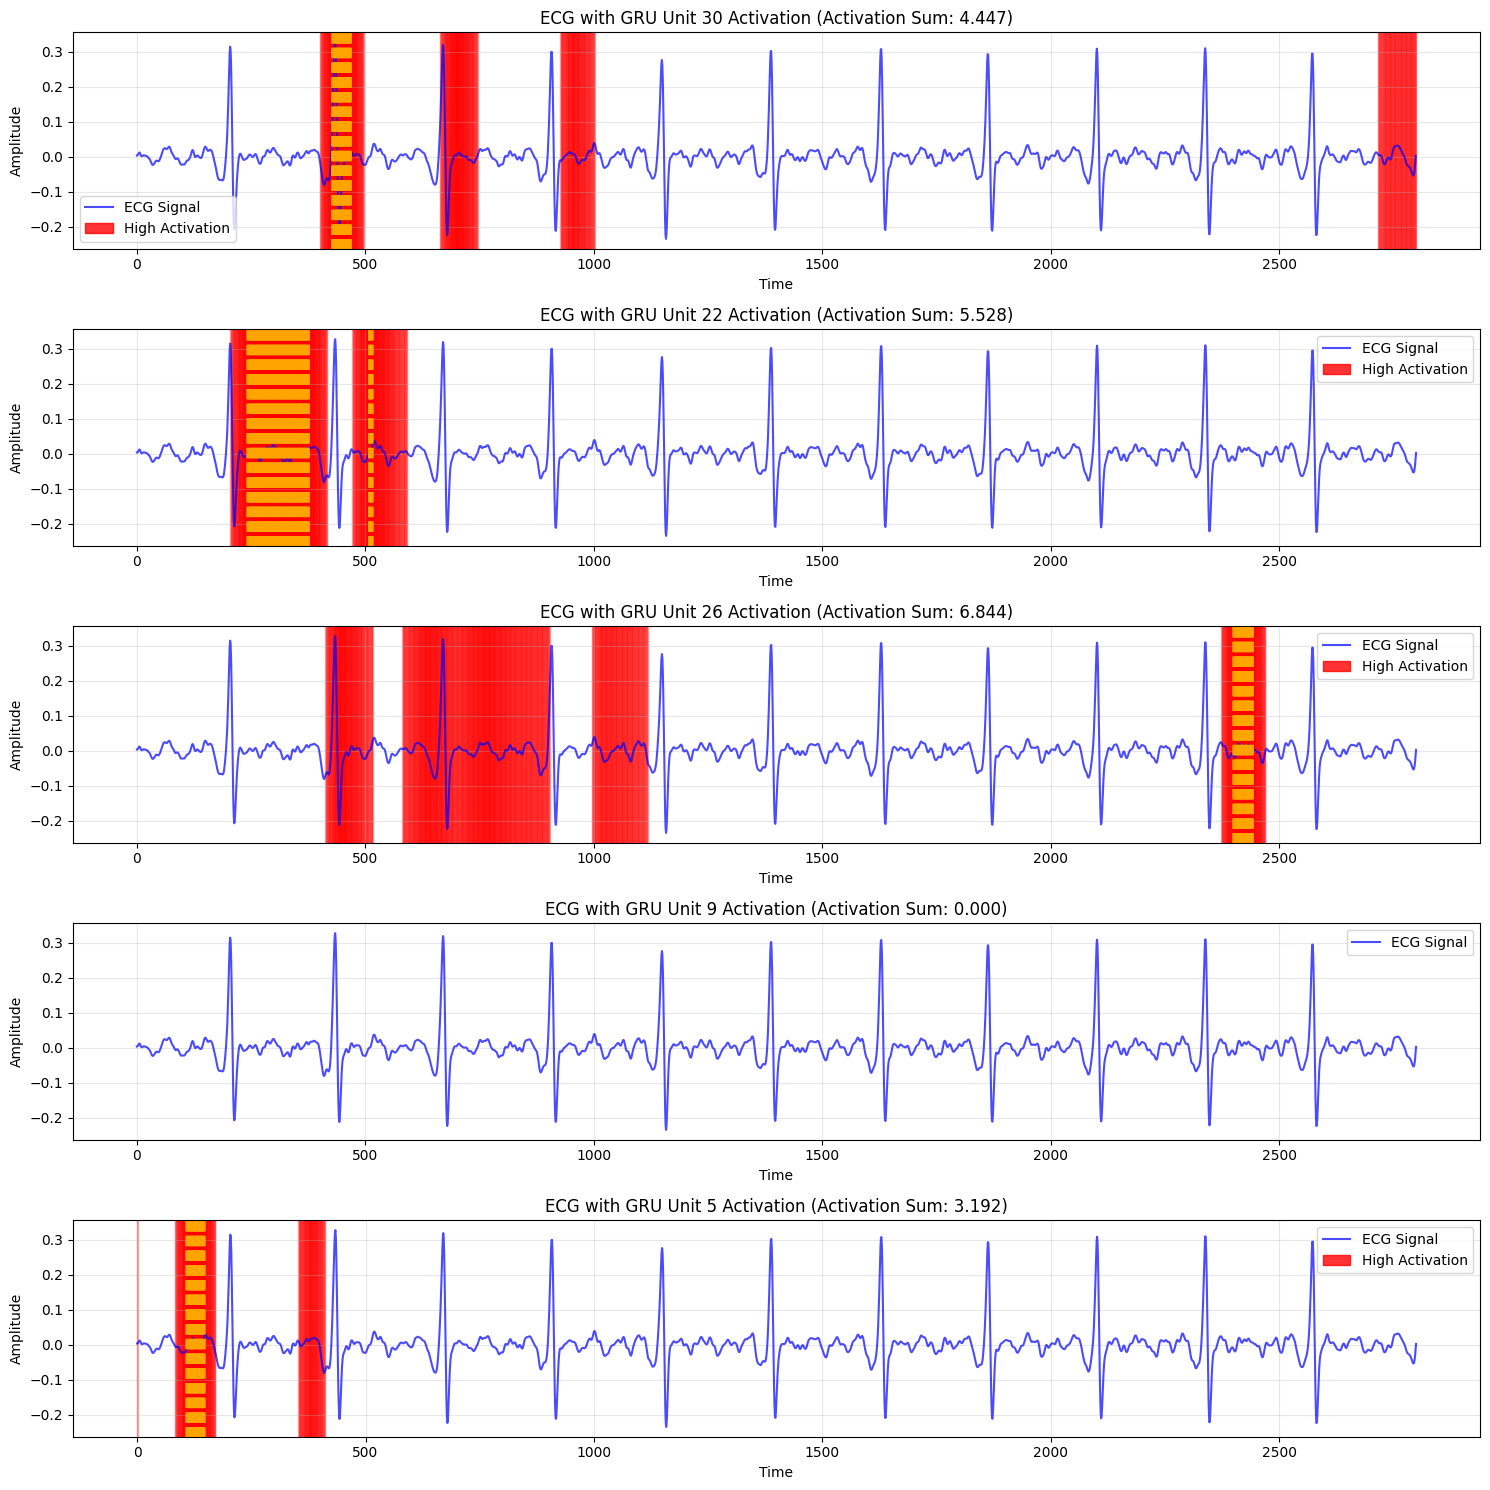

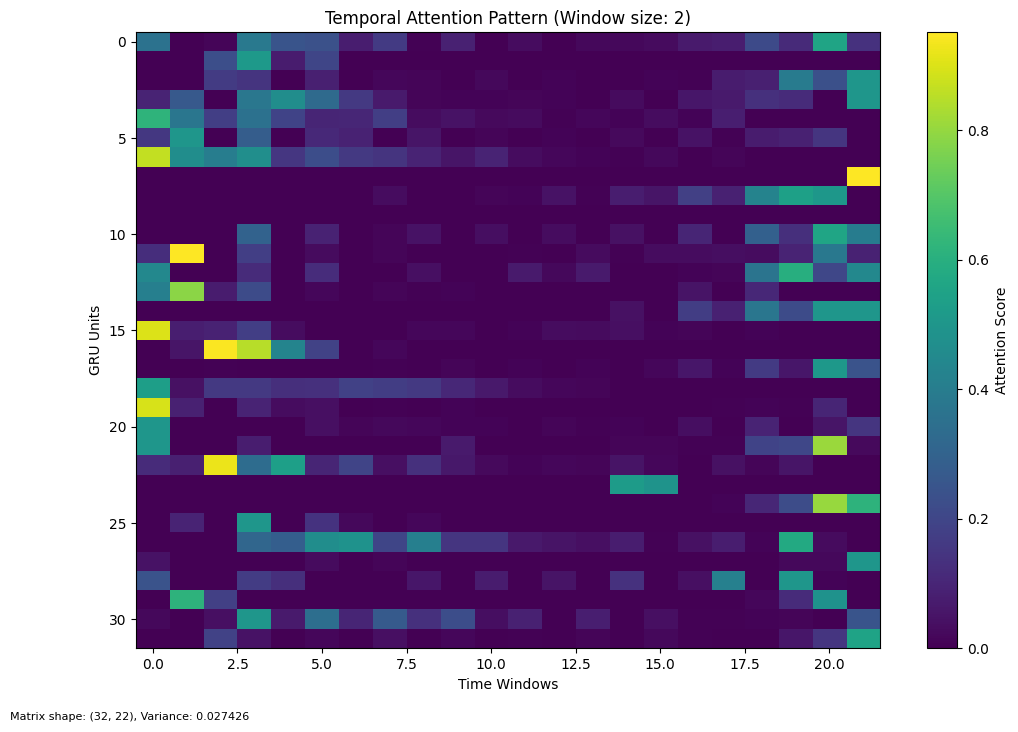

chagas: 0 - source: CODE-15%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
[[0.07338011]]


In [34]:
SAMPLE = 798

sample = X_test[SAMPLE]  # shape: (2800, 12)

heatmaps = make_all_gradcam_heatmaps(sample, model, last_conv_layer_name="conv_64")
spectrogram = get_spectrogram(model, sample)
# display_all_heatmaps_on_spectrogram(spectrogram, heatmaps)
display_all_heatmaps(heatmaps)

print(f"chagas: {y_test_info[SAMPLE]['Chagas label']} - source: {y_test_info[SAMPLE]['Source']}")
print(model.predict(tf.expand_dims(X_test[SAMPLE], axis=0)))

# Genera heatmaps per il modello GRU
heatmaps = make_all_gradcam_heatmaps_gru(sample, model, gru_layer_name="bigru_32_sequence")

# Visualizza le heatmaps
display_all_heatmaps_gru(heatmaps)

# Sovrappone le heatmaps sull'ECG con attivazioni più evidenti
display_heatmaps_on_ecg(sample, heatmaps, alpha=0.8, threshold=0.3, selected_units=[30, 22, 26, 9, 5])

# Analizza i pattern temporali con controlli migliorati
attention_matrix = analyze_temporal_attention(heatmaps, window_size=2)

print(f"chagas: {y_test_info[SAMPLE]['Chagas label']} - source: {y_test_info[SAMPLE]['Source']}")
print(model.predict(tf.expand_dims(X_test[SAMPLE], axis=0)))